In [1]:
!pip install torchcfm numpy==1.26.4 anndata==0.10.3 scanpy==1.9.6 matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 18.2 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 92.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 140.9 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 116.0 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 138.2 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 145.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 118.3 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 108.8 MB/s eta 0:00:01
     |████████████████████████████████| 865 kB 104.2 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 150.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 133.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 157.2 MB/s eta 0:00:01
     |████████████████████████████████| 42.4 MB 153.2 MB/s eta 0:00:01
     |███████████████

In [2]:
import numpy
print(numpy.__version__)

1.26.4


In [1]:
import torch
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('/dss/dsshome1/0F/di93quv/OT-CFM/src/')

from ot_cfm.data_utils import load_adata, create_training_dataloader, create_dataloader
from ot_cfm.model import create_ot_cfm_model
from ot_cfm.training import train_cfm, save_ot_cfm_model, load_ot_cfm_model, create_ot_cfm_optimizer
#from ot_cfm.transport import transport_pooled
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher

In [2]:
# When stuff not reloading properly...
import importlib
import ot_cfm
importlib.reload(ot_cfm)

<module 'ot_cfm' from '/dss/dsshome1/0F/di93quv/OT-CFM/src/ot_cfm/__init__.py'>

In [3]:
# Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# Load target2_moa dataset
target2_moa = load_adata("../data/Tim_target2_wellres_featuresimputed_druginfoadded_pycytominer.h5ad")
target2_moa

AnnData object with n_obs × n_vars = 50640 × 591
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Batch', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_InChIKey_standardized', 'Metadata_SMILES_standardized', 'Metadata_InChI_standardized', 'Metadata_pubchem_cid', 'Metadata_pert_iname', 'Metadata_clinical_phase', 'Metadata_target', 'Metadata_disease_area', 'Metadata_indication', 'Metadata_moa', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Objective_NA', 'Metadata_N_Brightfield_Planes_Min', 'Metadata_N_Brightfield_Planes_Max', 'Metadata_Distance_Between_Z_Microns', 'Metadata_Sites_Per_Well', 'Metadata_Filter_Configuration'
    uns: 'Metadata_Source_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [43]:
# Get the head of the 591 features
target2_moa.var.head()

""
Cells_AreaShape_BoundingBoxMaximum_X
Cells_AreaShape_Eccentricity
Cells_AreaShape_Extent
Cells_AreaShape_FormFactor
Cells_AreaShape_Orientation


In [5]:
import torch
torch.cuda.empty_cache()

In [13]:
# Init model
ot_cfm_model = create_ot_cfm_model(adata=target2_moa, use_pca=True, time_varying=True).to(device)
ot_cfm_optimizer = create_ot_cfm_optimizer(ot_cfm_model)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [7]:
ot_cfm_model

MLP(
  (layer1): Linear(in_features=60, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [33]:
target2_moa.obs["Metadata_Source"].unique()

['source_10', 'source_11', 'source_13', 'source_2', 'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8']
Categories (10, object): ['source_2', 'source_3', 'source_4', 'source_5', ..., 'source_8', 'source_10', 'source_11', 'source_13']

### Model:

* OT-CFM model uses an MLP architecture whichh predicts a velocity field for the data transformation It combines input features, one-hot source labels, and (if time_varying=True) a time variable.
* If we set time_varying=True, we add a time dimension to the input.
The MLP thn learns a continuous transformation as a function of time. This enables smooth trajectories when simulating transformations ( via Neural ODE).
* If time_varying=False, then no time variable is added.
The model learns a direct mapping between the source and target distributions, without modeling intermediate states.

In [8]:
# Hyperparameters
epochs = 10000  
batch_size = 1

In [9]:
dataset, dataloader = create_training_dataloader(
    target2_moa, batch_size=batch_size, exclude_source="source_2", use_pca=True
)

print(next(iter(dataloader))) 

{'source': {'x': tensor([[-2.9837, -5.6815,  1.6734,  2.9084, -1.0838,  2.0379, -0.6478, -0.9086,
         -1.9021,  1.3854, -1.1871,  1.5254,  0.8619,  0.6344, -2.9499, -2.7905,
          0.8594, -1.1473,  0.0552, -1.7254,  2.9801,  1.7666, -0.7370,  0.3909,
          0.7830,  1.3974,  1.0217,  0.1236, -0.0545, -2.7667,  0.7286,  0.0721,
         -0.3853,  0.8588, -1.4041,  0.6824,  0.0736,  0.7802, -1.2298,  0.5506,
          1.1917,  1.1992,  1.4735,  0.2133, -1.0041, -0.8040, -2.4725, -3.1020,
         -0.4762,  0.6094]]), 'moa': ['dihydroorotate dehydrogenase inhibitor|PDGFR ...]
Categories (1, object): ['dihydroorotate dehydrogenase inhibitor|PDGFR ...], 'cpd': ['JCP2022_094002']
Categories (1, object): ['JCP2022_094002'], 'microscope': ['CV8000']
Categories (1, object): ['CV8000']}, 'target': {'x': tensor([[-2.5625, -5.0285,  3.2049,  1.3874, -1.1991,  3.1132, -2.7377, -1.9633,
         -1.6547,  0.5252,  0.2232,  3.6357,  0.2994, -1.4814,  1.2111,  0.7980,
         -2.7676, -0.

In [10]:
print(next(iter(dataset))) 

{'source': {'x': tensor([[-3.5521, -5.9443,  0.8895,  2.3455, -1.2708,  3.5969, -0.4867,  0.8794,
          1.3028,  1.2240,  1.9904,  1.9720,  3.1643, -0.8850, -0.4281, -0.2169,
          1.4799, -1.5179,  0.4718,  0.1830,  0.0833, -0.7723,  1.2748, -0.2820,
          1.8181, -0.3720, -0.3652, -0.9439, -0.8160, -0.1971, -0.3401,  0.6779,
         -1.0518,  0.6955, -0.4840, -1.5444, -2.6595, -1.6837, -1.4502,  1.2267,
         -1.4153, -0.7096,  1.2190, -0.5739, -0.7235, -1.3175,  0.9934, -1.6069,
         -0.8799,  0.5484]]), 'moa': ['porcupine inhibitor']
Categories (1, object): ['porcupine inhibitor'], 'cpd': ['JCP2022_106781']
Categories (1, object): ['JCP2022_106781'], 'microscope': ['CV8000']
Categories (1, object): ['CV8000']}, 'target': {'x': tensor([[-2.9535, -4.2396,  1.9857,  1.4402, -1.2173,  1.9115,  2.6973,  2.4653,
          0.3960, -1.0986,  3.8744,  0.8976,  0.8230, -0.7665,  0.5228,  0.9137,
          3.7055, -5.8126, -2.9908, -0.9461,  3.4135, -1.0296, -3.4589,  0.27

In [11]:
for batch in dataloader:
    print("Source Batch:", batch["source"]["x"].shape)
    print("Source MOA:", batch["source"]["moa"])
    print("Source Compound:", batch["source"]["cpd"])
    print("Source Microscope:", batch["source"]["microscope"])
    print("Target Batch:", batch["target"]["x"].shape)
    print("Target MOA:", batch["target"]["moa"])
    print("Target Compound:", batch["target"]["cpd"])
    print("Target Microscope:", batch["target"]["microscope"])
    print("Source Label Shape:", batch["source_label"].shape)
    break  

Source Batch: torch.Size([1, 50])
Source MOA: ['antioxidant']
Categories (1, object): ['antioxidant']
Source Compound: ['JCP2022_028032']
Categories (1, object): ['JCP2022_028032']
Source Microscope: ['CV8000']
Categories (1, object): ['CV8000']
Target Batch: torch.Size([1, 50])
Target MOA: ['glutamate receptor antagonist']
Categories (198, object): ['11-beta hydroxysteroid dehydrogenase inhibitor', 'A1 adenosine receptor antagonist', 'AKT inhibitor', 'ALK tyrosine kinase receptor inhibitor', ..., 'ubiquitin specific protease inhibitor', 'uricosuric blocker', 'vasopressin receptor antagonist', 'vitamin K antagonist']
Target Compound: ['JCP2022_042261']
Categories (301, object): ['JCP2022_000794', 'JCP2022_001036', 'JCP2022_001275', 'JCP2022_001890', ..., 'JCP2022_116188', 'JCP2022_116437', 'JCP2022_116560', 'JCP2022_116749']
Target Microscope: ['CV8000']
Categories (1, object): ['CV8000']
Source Label Shape: torch.Size([1, 9])


### Training
The NN learns transformation velocities between pooled source data and the target domain.

Key Steps:
1. Sample batches of source and target data
2. Concatenate data with one-hot source encoding and (if time varying is true) time
3. Predict transformations using the OT-CFM model and compute MSE loss with the target (source 2 here!)
4. Backprop and update the model weights

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 50])) that is different to the input size (torch.Size([1, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10000, Loss: 48.584654834535385
Epoch 2/10000, Loss: 332.59134115113153
Epoch 3/10000, Loss: 442.5274621910519
Epoch 4/10000, Loss: 198.64363177617392
Epoch 5/10000, Loss: 330.4181233247121
Epoch 6/10000, Loss: 8.207472880681356
Epoch 7/10000, Loss: 5408.903378725052
Epoch 8/10000, Loss: 3.0719451904296875
Epoch 9/10000, Loss: 5.102523114946154
Epoch 10/10000, Loss: 430.75366735458374
Epoch 11/10000, Loss: 405.48857537905377
Epoch 12/10000, Loss: 2049.555435260137
Epoch 13/10000, Loss: 17.871103551652695
Epoch 14/10000, Loss: 32.30914753013187
Epoch 15/10000, Loss: 176.87592498461404
Epoch 16/10000, Loss: 342.7230434682634
Epoch 17/10000, Loss: 67.56388574176364
Epoch 18/10000, Loss: 19.062743107477825
Epoch 19/10000, Loss: 294.72907463709515
Epoch 20/10000, Loss: 207.44806045956082
Epoch 21/10000, Loss: 7.085100862714979
Epoch 22/10000, Loss: 3.199911779827542
Epoch 23/10000, Loss: 1937.8570703400505
Epoch 24/10000, Loss: 444.2182450824314
Epoch 25/10000, Loss: 11.030055284500

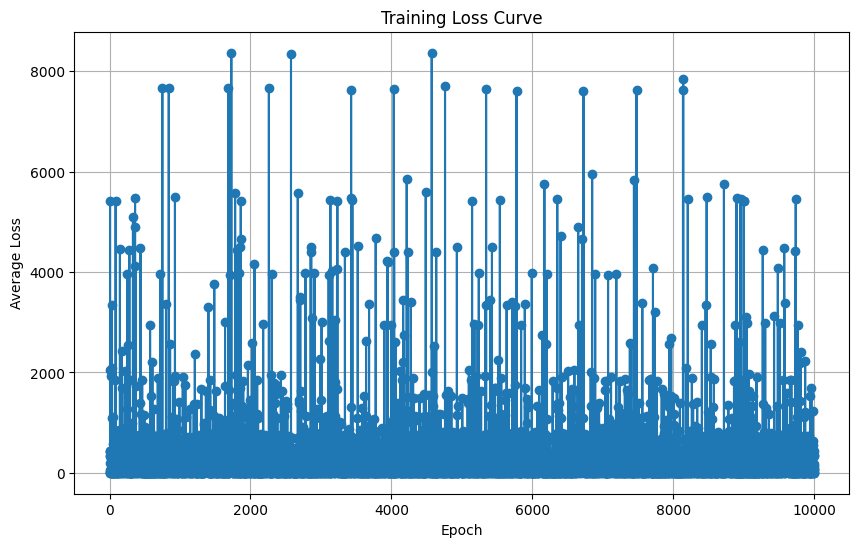

In [12]:
trained_model2 = train_cfm(ot_cfm_model, ot_cfm_optimizer, FM, dataloader, device, epochs=epochs, plot_loss=True)

In [13]:
# save
save_ot_cfm_model(trained_model2, ot_cfm_optimizer, "../results/ot_cfm_pooled_time_var_false_10000.pt")

In [5]:
# Load the saved model and optimizer
checkpoint = torch.load("../results/ot_cfm_pooled_time_var_false_10000.pt")

# Extract model and optimizer
ot_cfm_model = checkpoint["model"]
ot_cfm_optimizer = checkpoint["optimizer"]

### Transport

1. Transports all sources to a target domain ( source_2)
2. Uses NeuralODE to simulate transformation trajectories
3. Output transformed data in as adata

Specifically, this function extracts all unique sources from adata.obs["Metadata_Source"] and sets one of them as the target source (here: "source_2"). All other sources are stored in source_list, which includes all sources except the target. A dataloader is created for each source, splitting its data into batches. Each source (excluding the target) is assigned a one-hot vector, where:
* The length of the vector is equal to the total number of sources.
* The position corresponding to the current source is set to 1, while others are 0.
This one-hot vector is used as an additional conditioning input for the model.

For each batch from each source the batch is passed through a NeuralODE model (ot_cfm_model), conditioned on its one-hot vector.
The model generates a trajectory over time and extracts the final transported state.
The transported features (x_transported) are stored along with the original source batch.
Metadata for both the original and transported data is stored in annot_combined.

In [6]:
import numpy as np
import scanpy as sc
from torchdyn.core import NeuralODE
from torchcfm.utils import torch_wrapper
import torch
import torch.nn as nn
import pandas as pd

class TorchWrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""
    def __init__(self, model, c):
        super().__init__()
        self.model = model
        self.c = c  # One-hot encoding of source domain

    def forward(self, t, x, *args, **kwargs):
        time = t.view(-1, 1).expand(x.shape[0], -1)  # [batch_sze, 1]

        # Ensure source_one_hot is correctly shaped 
        source_one_hot = self.c.expand(x.shape[0], -1)  # [batch_size, num_sources]

        # Expand sourcce_one_hot across sequence length to match x's sequence length
        source_one_hot = source_one_hot.unsqueeze(1).expand(-1, x.shape[1], -1)  # [batch_size, seq_len, num_sources]

        # # Expand x to 3D (batch_size, seq_len, feature_dim)
        x = x.unsqueeze(1).expand(-1, source_one_hot.shape[1], -1)  

        # Ensure time is also expanded across sequence length to match
        time = time.unsqueeze(1).expand(-1, x.shape[1], -1)  # [batch_size, seq_len, 1]

        # Debugging: Checking shapes before passing to model...
        print(f"x shape: {x.shape}")  # [batch_size, seq_len, feature_dim]
        print(f"time shape: {time.shape}")  # [batch_size, seq_len, 1]
        print(f"source_one_hot shape: {source_one_hot.shape}")  # [batch_size, seq_len, num_sources]

        # Concat inputs along the feature dimension
        x = torch.cat([x, source_one_hot, time], dim=-1)  # Concatenate source_batch, source_one_hot, and time

        # Debugging: Checking the concatenated shape
        print(f"Concatenated x shape: {x.shape}")  # [batch_size, seq_len, feature_dim + num_sources + 1]

        # Pass input to the model
        return self.model(x, source_one_hot, time)

NOTE! Installing ujson may make loading annotations faster.


In [7]:
import torch
import scanpy as sc
import numpy as np
import pandas as pd
from torchdyn.core import NeuralODE
from torchcfm.utils import torch_wrapper
from torch.utils.data import DataLoader

def transport_pooled(adata, ot_cfm_model, target_source="source_2", batch_size=64, device="cpu", save_adata_path=None):
    """Transport each source separately, conditioning on its one-hot vector"""

    num_sources = len(adata.obs["Metadata_Source"].unique())
    source_list = [src for src in adata.obs["Metadata_Source"].unique() if src != target_source]

    # Create Single Source DataLoaders
    source_dataloaders = {
        source: create_dataloader(adata, source, batch_size=batch_size)
        for source in source_list
    }

    X_combined, annot_combined = [], pd.DataFrame()

    # Iterate over each source and transport separately
    for source in source_list:
        source_idx = source_list.index(source)  # Gett index for one-hot encoding
        one_hot_source = torch.eye(num_sources)[source_idx].to(device)  #One-hot encoding for source
        source_dataloader = source_dataloaders[source]

        #wrap the model for NeuralODE, conditioning on the one-hot source
        wrapped_model = TorchWrapper(ot_cfm_model, one_hot_source)
        node = NeuralODE(wrapped_model, solver="dopri5", sensitivity="adjoint")

        # Trransport each batch separately
        for batch in source_dataloader:
            source_batch = batch["x"].to(device)  
            source_moa = batch["moa"]
            source_cpd = batch["cpd"]
            source_microscope = batch["microscope"]

            with torch.no_grad():
                traj = node.trajectory(
                    source_batch.float(),
                    t_span=torch.linspace(0, 1, 100),
                ).cpu()

            x_transported = traj[-1].detach().numpy()
            del traj

            # Store transported and original data
            X_combined.append(np.concatenate([x_transported, source_batch.cpu().numpy()], axis=0))

            # Create annotations for AnnData
            annot1 = {
                "Metadata_Source": [f"{source}_to_{target_source}"] * len(source_moa),
                "Metadata_moa": source_moa,
                "Metadata_JCP2022": source_cpd,
                "Metadata_Microscope_Name": source_microscope,
            }
            annot2 = {
                "Metadata_Source": [target_source] * len(source_moa),
                "Metadata_moa": source_moa,
                "Metadata_JCP2022": source_cpd,
                "Metadata_Microscope_Name": source_microscope,
            }

            annot_batch = pd.concat([pd.DataFrame(annot1), pd.DataFrame(annot2)], axis=0)
            annot_combined = pd.concat([annot_combined, annot_batch], axis=0)

    # Combine transported data into adata
    X_combined = np.concatenate(X_combined, axis=0)
    full_adata = sc.AnnData(X=X_combined, obs=annot_combined)
    full_adata.obsm["X_pca"] = full_adata.X.copy()

    if save_adata_path:
        full_adata.write(save_adata_path)

    return full_adata

In [8]:
target_source = "source_2"
batch_size = 1  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run the transport function
transported_adata = transport_pooled(
    adata=target2_moa, 
    ot_cfm_model=ot_cfm_model, 
    target_source=target_source, 
    batch_size=batch_size, 
    device=device, 
    save_adata_path="../results/transported_data.h5ad"  
)


transported_adata

x shape: torch.Size([1, 50, 50])
time shape: torch.Size([1, 50, 1])
source_one_hot shape: torch.Size([1, 50, 10])
Concatenated x shape: torch.Size([1, 50, 61])


RuntimeError: expand(torch.cuda.FloatTensor{[1, 1, 50, 61]}, size=[-1, 50, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [ ]:
# Perform PCA and UMAP on transformed AnnData
sc.tl.pca(transformed_adata, n_comps=50)
sc.pp.neighbors(transformed_adata, n_neighbors=15) 
sc.tl.umap(transformed_adata)

# Save the PCA and UMAP results
#transformed_adata.write("../results/transformed_adata_with_embeddings.h5ad")

In [ ]:
# Plot PCA
sc.pl.pca(
    transformed_adata,
    color="Metadata_Source",  
    save="../results/transformed_pca.png",  
    show=True
)

In [ ]:
# Plot UMAP
sc.pl.umap(
    transformed_adata,
    color="Metadata_Source",  
    save="../results/transformed_umap.png",
    show=True
)

### time_varying = True setting 

In [14]:
# Hyperparameters
epochs = 10000
batch_size = 1

In [15]:
# Init model
ot_cfm_model = create_ot_cfm_model(adata=target2_moa, use_pca=True, time_varying=True).to(device)
ot_cfm_optimizer = create_ot_cfm_optimizer(ot_cfm_model)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [16]:
dataset, dataloader = create_training_dataloader(
    target2_moa, batch_size=batch_size, exclude_source="source_2", use_pca=True
)

print(next(iter(dataloader))) 

{'source': {'x': tensor([[-2.6804, -6.8713,  2.0804, -1.6216, -0.2718,  4.2733,  3.0506, -1.9974,
          0.2095,  1.5787, -0.4368,  0.2841,  3.3290, -1.2143,  0.8133, -0.4696,
         -0.9592,  1.6957, -0.1225,  0.8378,  0.6737, -1.7681, -3.6017, -0.3133,
          0.7418,  0.6672,  0.5959, -0.4372,  0.6095,  1.2130,  0.6341, -0.0154,
         -0.2544,  1.4521,  3.5487, -1.6651, -0.7542, -1.3992,  0.6858, -0.5937,
          0.2123, -0.4599, -0.8056, -0.3815,  2.9638, -1.0373,  1.5375,  0.2611,
          0.9504, -2.0939]]), 'moa': ['control vehicle']
Categories (1, object): ['control vehicle'], 'cpd': ['JCP2022_033924']
Categories (1, object): ['JCP2022_033924'], 'microscope': ['ImageXpress Micro Confocal']
Categories (1, object): ['ImageXpress Micro Confocal']}, 'target': {'x': tensor([[-3.2496, -7.0626, -0.5763,  1.5569, -2.1645, -0.7977,  0.6993, -0.4365,
          1.8157, -0.9782, -0.5358,  1.8625, -2.1145, -1.3505, -0.1668,  2.4928,
         -1.1186,  2.6147,  3.3893, -0.6614, 

Epoch 1/10000, Loss: 10.656205230289036
Epoch 2/10000, Loss: 69.08596234851413
Epoch 3/10000, Loss: 1029.4687440130447
Epoch 4/10000, Loss: 40.94215374522739
Epoch 5/10000, Loss: 7.1880684163835316
Epoch 6/10000, Loss: 222.9268593258328
Epoch 7/10000, Loss: 33.63896232181125
Epoch 8/10000, Loss: 23.01918297343784
Epoch 9/10000, Loss: 13.843128416273329
Epoch 10/10000, Loss: 28.625208775202434
Epoch 11/10000, Loss: 705.3667857646942
Epoch 12/10000, Loss: 337.9482896592882
Epoch 13/10000, Loss: 361.0718295574188
Epoch 14/10000, Loss: 40.78115304311117
Epoch 15/10000, Loss: 318.0323184331258
Epoch 16/10000, Loss: 23.92923315366109
Epoch 17/10000, Loss: 34.53824983702766
Epoch 18/10000, Loss: 20.474218050638836
Epoch 19/10000, Loss: 68.51944780349731
Epoch 20/10000, Loss: 3.9027275244394937
Epoch 21/10000, Loss: 8.740025414360893
Epoch 22/10000, Loss: 10.547522399160597
Epoch 23/10000, Loss: 36.147843307918976
Epoch 24/10000, Loss: 78.60136479801602
Epoch 25/10000, Loss: 89.07676770952013


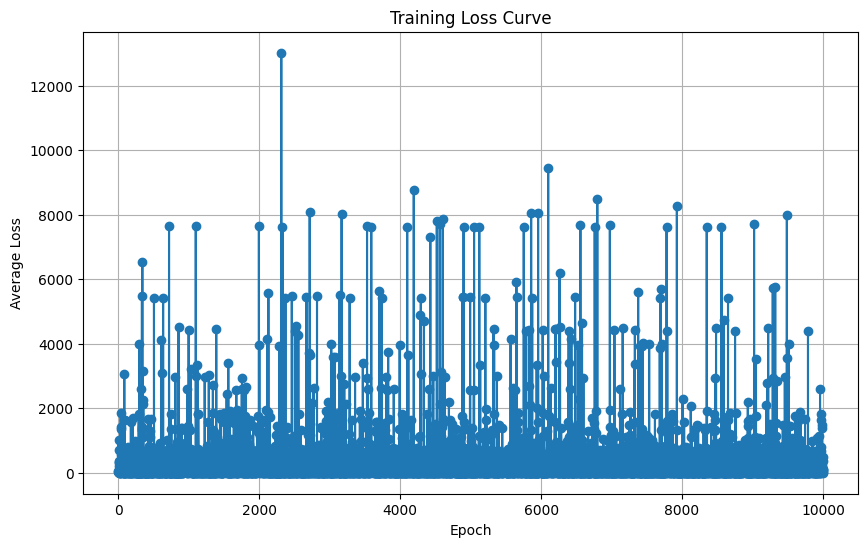

In [17]:
trained_model = train_cfm(ot_cfm_model, ot_cfm_optimizer, FM, dataloader, device, epochs=epochs, plot_loss=True)

In [18]:
# save
save_ot_cfm_model(trained_model, ot_cfm_optimizer, "../results/ot_cfm_pooled_time_var_true_10000.pt")

In [39]:
# Load the saved model and optimizer
checkpoint = torch.load("../results/ot_cfm_pooled_time_var_true_10000.pt")

# Extract model and optimizer
ot_cfm_model = checkpoint["model"]
ot_cfm_optimizer = checkpoint["optimizer"]